# B_HIT.SR module - Integrative analysis between spatial transcriptome and BCRs

## Import packages 

In [1]:
import os
import BAITS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


## Import files

In [3]:
bcr_loc_df = pd.read_csv('/home/zhaoyp/1.CRLM_XCR/0.github/docs/notebooks/data/bcr_rep_loc_twoSamples_sampled.tsv', sep='\t',index_col=0)


In [4]:
bcr_loc_df.head(n=2)


,sample,bcUmi,clone,aaClone,family_id,Vgene,Jgene,Cgene,X,Y,spatial_cluster,tissue_region,InAggOrNot,Bcell_aggregate_label,BaggArea
16971791,P0516-LM,E14D5FEFEBE3D5C47,TGTCAACAGAGTCACAGTATACCTACTTTT_CQQSHSIPTF_IGKV...,CQQSHSIPTF_IGKV1-39_IGKJ2_IGK,IGK_family_3889,IGKV1-39,IGKJ2,IGK,11873,3350,C3: TIL+ activation,Peri-tumor,InAgg,P0516_LM-12,1789700.0
11188026,P0516-LM,8E153B79054792CA2,TGTCAACAATATAGCACTGTCCCCCTCACTTTC_CQQYSTVPLTF_...,CQQYSTVPLTF_IGKV1-27_IGKJ4_IGK,IGK_family_3718,IGKV1-27,IGKJ4,IGK,7616,5287,C3: TIL+ activation,Adjacent-tissue,InAgg,P0516_LM-12,1789700.0


## Define parameters

In [5]:

sample_key = 'sample'
Umi_key = 'bcUmi'
clone_key = 'clone'
cdr3nt_col = 'cdr3nt'

Vgene_col = 'Vgene'
Jgene_col = 'Jgene'
Cgene_key = 'Cgene'

loc_x_key = 'X'
loc_y_key='Y'


## QC

Compute the clone number and UMIs of spatial location (at the bin1 level)

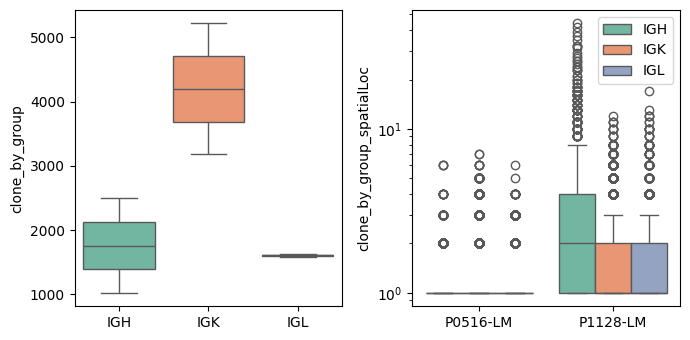

In [6]:
bcr_loc_df = B_HIT.VDJ.tl.calculate_qc_clones( bcr_loc_df, sample_key, Cgene_key, clone_key, loc_x_key=loc_x_key, loc_y_key=loc_y_key, plot=True ) 


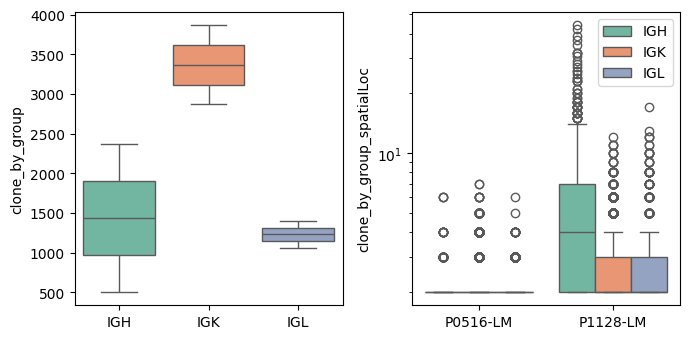

In [7]:
bcr_loc_df = B_HIT.VDJ.tl.filter_clones_spatial(bcr_loc_df, 'clone_by_group_spatialLoc', min_clone_spatial=1)
bcr_loc_df = B_HIT.VDJ.tl.calculate_qc_clones( bcr_loc_df, sample_key, Cgene_key, clone_key, plot=True ) 


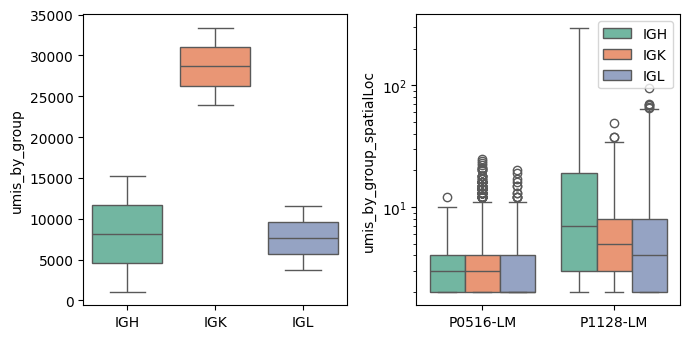

In [9]:
bcr_loc_df = B_HIT.VDJ.tl.calculate_qc_umis( bcr_loc_df, sample_key, Cgene_key, clone_key, plot=False ) 

bcr_loc_df = B_HIT.VDJ.tl.filter_umi_spatial(bcr_loc_df, 'umis_by_group_spatialLoc', min_umi_spatial=1)
bcr_loc_df = B_HIT.VDJ.tl.calculate_qc_umis( bcr_loc_df, sample_key, Cgene_key, clone_key, plot=True ) 


## Plot XCR 

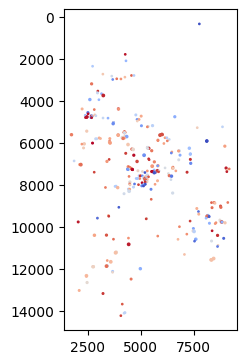

In [10]:
B_HIT.VDJ.pl._plot_xcr( bcr_loc_df[(bcr_loc_df[sample_key]=='P0516-LM') & (bcr_loc_df[Cgene_key]=='IGH')], clone_key,loc_x_key, loc_y_key ) 

## Basic statistics

Provide the groups and calculate the corrsponding index (based on spatial location)

### shannon_entropy (based on spatial location

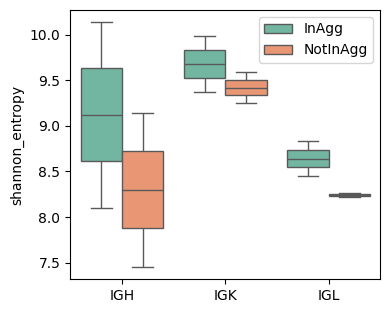

In [11]:
groups = [sample_key, Cgene_key, 'InAggOrNot']
shannon_entropy_df = B_HIT.VDJ.tl.compute_grouped_index(bcr_loc_df, sample_key, Cgene_key, clone_key, groups, loc_x_key=loc_x_key, loc_y_key=loc_y_key, index='shannon_entropy')

fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
B_HIT.VDJ.pl._boxplot(shannon_entropy_df, 'Cgene', 'shannon_entropy', groupby='InAggOrNot', palette='Set2', xlabel=None, ylabel='shannon_entropy', log=False, ax=ax )
plt.show()


### gini_index (based on spatial location

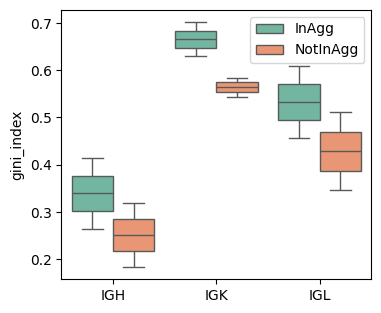

In [12]:
groups = [sample_key, Cgene_key, 'InAggOrNot']
gini_index_df = B_HIT.VDJ.tl.compute_grouped_index(bcr_loc_df, sample_key, Cgene_key, clone_key, groups, loc_x_key=loc_x_key, loc_y_key=loc_y_key, index='gini_index')

fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
B_HIT.VDJ.pl._boxplot(gini_index_df, 'Cgene', 'gini_index', groupby='InAggOrNot', palette='Set2', xlabel=None, ylabel='gini_index', log=False, ax=ax )
plt.show()


### renyi_entropy (based on spatoal location

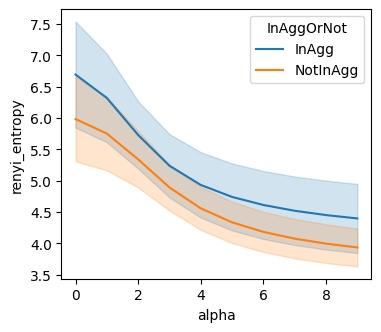

In [13]:
groups = [sample_key, Cgene_key, 'InAggOrNot']
renyi_entropy_df =  B_HIT.VDJ.tl.compute_grouped_index(bcr_loc_df, sample_key, Cgene_key, clone_key, groups, loc_x_key=loc_x_key, loc_y_key=loc_y_key, index='renyi_entropy')

fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
sns.lineplot(data=renyi_entropy_df[renyi_entropy_df[Cgene_key]=='IGH'], x="alpha", y="renyi_entropy", hue='InAggOrNot', ax=ax )
plt.show()


### Corrlation between computed_index and the area of the B_aggregates

In [14]:
agg_clone_df = B_HIT.VDJ.tl.calculate_qc_clones( bcr_loc_df, 'Bcell_aggregate_label', Cgene_key, clone_key, plot=False ) 


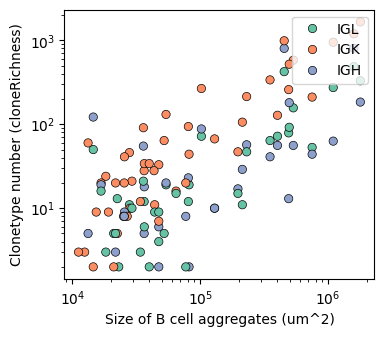

In [16]:
plot_df = agg_clone_df[['sample', 'Cgene', 'BaggArea','clone_by_group']].drop_duplicates().dropna() 

fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
B_HIT.VDJ.pl._scatter_plot(plot_df, 'BaggArea', 'clone_by_group', groupby='Cgene', palette='Set2', x_log=True, y_log=True, 
             xlabel='Size of B cell aggregates (um^2)', ylabel='Clonetype number (cloneRichness)', ax=ax )
plt.show()
